社团结构划分，使用CNM算法，导入真实数据集进行测试

In [48]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import igraph as ig

使用igraph构建网络的简单操作

In [4]:
g=ig.Graph()
g = ig.Graph(n=10, edges=[[0, 1], [0, 5]])
print(g)
ig.summary(g)

IGRAPH U--- 10 2 --
+ edges:
0--1 0--5
IGRAPH U--- 10 2 -- 


In [98]:
#加载真实网络数据集
# 3. 蛋白质交互网络
df3 = pd.read_csv("./real-data/protein_interaction.csv")
G1 = nx.from_pandas_edgelist(df3, 'source', 'target', create_using = nx.Graph())
G1=nx.to_undirected(G1)
Matrix=nx.adjacency_matrix(G1)
Matrix=Matrix.todense()
G=ig.Graph.Adjacency(Matrix.tolist())
ig.summary(G)
G.to_undirected()
print(G.is_directed())

IGRAPH D--- 2018 5635 -- 
False


In [112]:
#generate a tuple to get the return value
community=G.community_fastgreedy()
print(community)
# Extract the clusters from the dendrogram at a specific level
level = 1  # Adjust the level according to your needs
n_clusters = int(level * community.optimal_count)  # Convert level to an integer
clusters = community.as_clustering(n_clusters)
# Print the modularity score for the optimal clustering
modularity_score = community.optimal_count
print(f"Modularity score for the optimal clustering: {modularity_score}")

# Print the community assignments
for i, cluster in enumerate(clusters):
    print(f"Community {i+1}: {cluster}")


Dendrogram, 4000 elements, 3999 merges
Modularity score for the optimal clustering: 3
Community 1: [0, 4, 7, 8, 10, 12, 14, 17, 18, 19, 21, 22, 25, 29, 31, 35, 40, 42, 44, 45, 46, 48, 51, 53, 58, 59, 61, 62, 64, 69, 70, 72, 76, 80, 81, 83, 85, 88, 89, 90, 91, 95, 97, 100, 104, 106, 107, 113, 117, 118, 120, 122, 123, 127, 128, 129, 131, 138, 139, 141, 145, 146, 148, 149, 152, 155, 159, 160, 161, 162, 163, 164, 165, 170, 171, 172, 173, 174, 175, 176, 177, 179, 180, 181, 182, 183, 184, 186, 188, 192, 193, 195, 196, 197, 199, 202, 204, 205, 206, 207, 208, 212, 213, 216, 217, 218, 219, 223, 224, 225, 227, 228, 229, 231, 232, 233, 234, 236, 239, 240, 243, 244, 245, 247, 250, 252, 253, 255, 256, 257, 259, 262, 263, 265, 267, 271, 272, 274, 275, 276, 277, 280, 282, 283, 288, 289, 292, 293, 295, 296, 298, 299, 303, 305, 306, 308, 309, 310, 311, 313, 316, 317, 318, 322, 326, 327, 328, 329, 330, 332, 334, 335, 336, 337, 344, 346, 348, 349, 350, 351, 353, 355, 356, 357, 360, 361, 362, 363, 366, 36

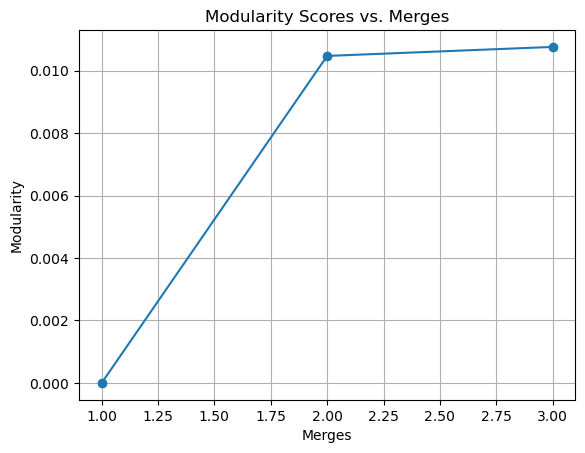

In [113]:
# Extract the clustering at each level and calculate the modularity score
modularity_scores = []
for level in range(community.optimal_count):
    clusters = community.as_clustering(level+1)
    modularity = clusters.modularity
    modularity_scores.append(modularity)

# Create a list of merges
merges = range(1, len(modularity_scores)+1)
# Plot the data
plt.plot(merges, modularity_scores, marker='o')
plt.xlabel('Merges')
plt.ylabel('Modularity')
plt.title('Modularity Scores vs. Merges')
plt.grid(True)
plt.show()